<h1>Máster de Ciencia de Datos e Ingenieria de computadores.</h1>
<h2> Visión por Computador </h2>
<h3> <strong> Autores: </strong>Brian Sena Simons y Miguel García López </h3>

<img style="display:block;margin-left:auto;margin-right:auto;width:50%;" alt="Bandas de colores del satélite landsat 7" src="Landsat7-bands.jpg" title="Significado de las bandas del satélite Landsat-7"/>

# Inúndación Texas

/home/briansenas/Documents/landsat-remote-sensing/.venv/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


dtype: uint8, shape: (1024, 1024), min: 0, max: 255


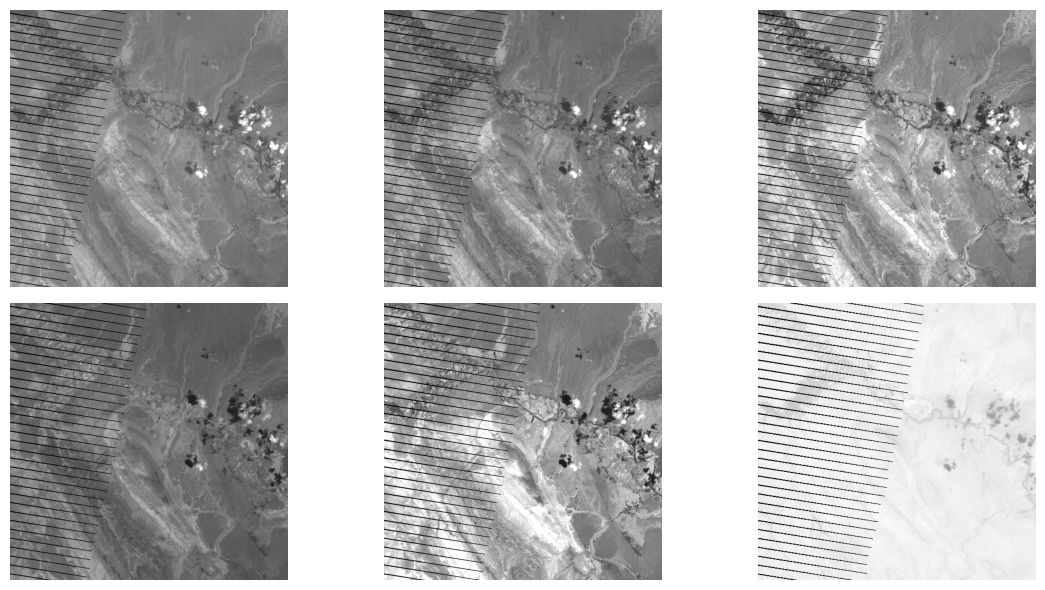

In [1]:
import os 
import glob
import cv2
import rasterio
import matplotlib.pyplot as plt
import numpy as np

texas_path = os.path.join("Lansat", "texas")
texas_imgs_files = sorted(glob.glob(os.path.join(texas_path, "agosto_banda*.tif")))
texas_imgs = list(map(lambda x: rasterio.open(x).read(1).astype(np.uint8), texas_imgs_files))
texas_sample = texas_imgs[0]
print(f'dtype: {texas_sample.dtype}, shape: {texas_sample.shape}, min: {np.min(texas_sample)}, max: {np.max(texas_sample)}')

def plot_array(rows: int, cols: int, data: list, cmap='gray', **kwargs):
  """Plots an array given the rows and cols"""
  fig, ax = plt.subplots(rows, cols, **kwargs)
  ax = ax.ravel()
  for i, img in enumerate(data[:rows*cols]):
      ax[i].imshow(img, cmap)
  return fig, ax

fig, ax = plot_array(2, 3, texas_imgs, tight_layout=True, figsize=(12,6))
for i in range(len(ax)):
  ax[i].set_axis_off()
plt.show()

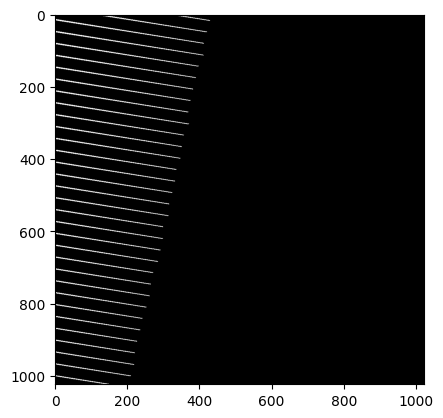

In [2]:
# Filter the black lines
black_artifact_thresh = 10
mask = (texas_imgs[0] < black_artifact_thresh).astype(np.uint8)
plt.imshow(mask, 'gray')
plt.show()

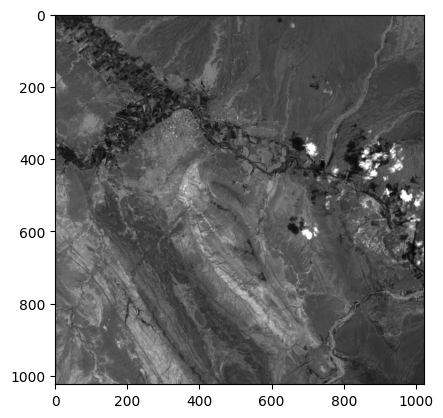

In [3]:
# Review inpainting
rec = cv2.inpaint(texas_imgs[0], mask.astype(np.uint8), 3, cv2.INPAINT_TELEA)
plt.imshow(rec, 'gray')
plt.show()

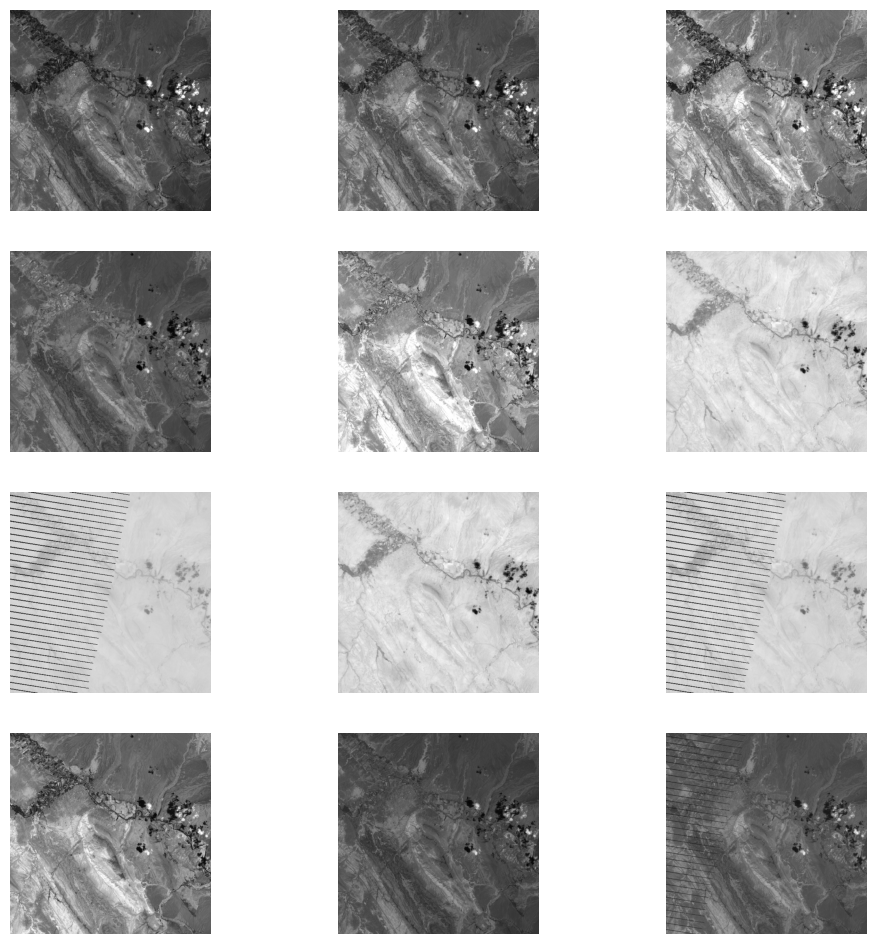

In [4]:
# Set threshold for detecting black pixels
black_artifact_thresh = 10
# Create image masks
texas_imgs_masks = list(map(lambda x: (x < black_artifact_thresh).astype(np.uint8), texas_imgs))
# Interpolate over the black pixels masks
texas_imgs_clean = list(map(lambda img, mask: cv2.inpaint(img, mask, 1, cv2.INPAINT_TELEA), texas_imgs, texas_imgs_masks))
# Plot the results
fig, ax = plot_array(4, 3, texas_imgs_clean, figsize=(12,12))
for i in range(len(ax)):
  ax[i].set_axis_off()
plt.show()

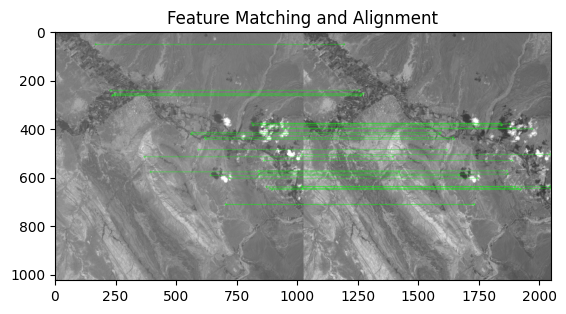

(1024, 1024)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def align_band(img1: np.ndarray, img2: np.ndarray, threshold: float = 0.7, visualize: bool = False) -> np.ndarray:
  """
  Aligns img2 to img1 using SIFT feature matching and homography transformation.
  Code adapted from: https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html

  Parameters:
  img1 (np.ndarray): Reference image (1-channel).
  img2 (np.ndarray): Image to be aligned (1-channel).
  threshold (float): Lowe's ratio test threshold for filtering good matches.
  visualize (bool): If True, displays the matching keypoints and transformation.

  Returns:
  np.ndarray: Aligned version of img2 (1-channel).
  """
  MIN_MATCH_COUNT = 10
  
  # Initialize SIFT detector
  sift = cv2.SIFT_create()
  
  # Detect keypoints and compute descriptors
  keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
  keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
  
  # FLANN-based matcher parameters
  index_params = dict(algorithm=1, trees=5)  # FLANN_INDEX_KDTREE = 1
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  
  # Find matches using KNN
  matches = flann.knnMatch(descriptors1, descriptors2, k=2)
  
  # Apply Lowe's ratio test
  good_matches = [m for m, n in matches if m.distance < threshold * n.distance]
  
  if len(good_matches) >= MIN_MATCH_COUNT:
    # Extract matched keypoints
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Compute homography matrix
    homography_matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Warp img2 to align with img1
    height, width = img1.shape
    aligned_img = cv2.warpPerspective(img2, homography_matrix, (width, height))
    
    if visualize:
      matches_mask = mask.ravel().tolist()
      draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matches_mask, flags=2)
      img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, **draw_params)
      plt.imshow(img_matches, cmap='gray')
      plt.title("Feature Matching and Alignment")
      plt.show()
    
    return aligned_img
  else:
    print(f"Not enough matches found: {len(good_matches)}/{MIN_MATCH_COUNT}")
    return img2  # Return original image if alignment fails

aligned = align_band(texas_imgs_clean[0], texas_imgs_clean[1], threshold=0.1, visualize=True,)
print(aligned.shape)

In [6]:
green_band = texas_imgs_clean[np.strings.endswith(texas_imgs_files, 'banda2.tif').nonzero()[0][0]]
nir_band = texas_imgs_clean[np.strings.endswith(texas_imgs_files, 'banda4.tif').nonzero()[0][0]]

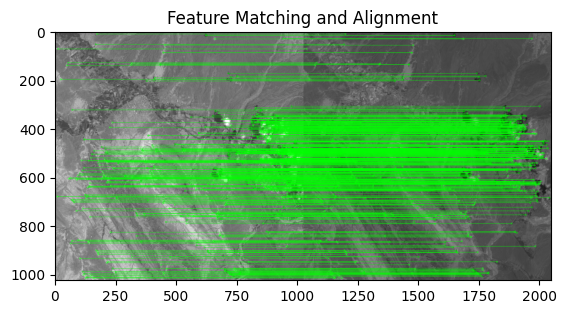

In [7]:
aligned_nir= align_band(green_band, nir_band, visualize=True)

In [8]:
# Compute NDWI using OpenCV
green_band = green_band.astype(np.float32)
aligned_nir = aligned_nir.astype(np.float32)
ndwi = cv2.divide(cv2.subtract(green_band, aligned_nir), cv2.add(green_band, aligned_nir + 1e-10))
# Normalize to 0-255 for visualization
ndwi_vis = cv2.normalize(ndwi, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

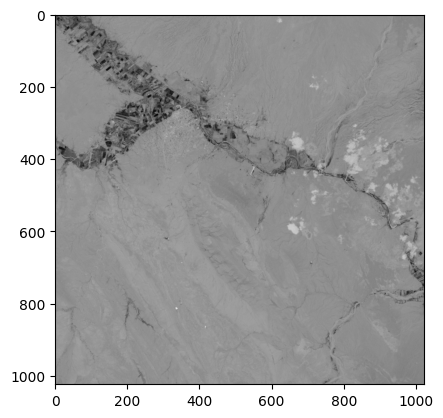

In [9]:
plt.imshow(ndwi_vis, 'gray')
plt.show()

In [10]:
import numpy as np
# thresh de NDWI 
# How to interpret NDWI: https://eos.com/make-an-analysis/ndwi/
thresh = 0.2  # NDWI > 0 indica water
# Crear una máscara binaria donde NDWI > thresh (water = 1, no water = 0)
mask_water = np.where(ndwi > thresh, 1, 0).astype(np.uint8)
# Calcular el número de píxeles de water
num_pixels_water = np.sum(mask_water)
# 30 meters per pixel except for band8 with 15
# https://www.usgs.gov/landsat-missions/landsat-7
# https://www.usgs.gov/centers/eros/science/usgs-eros-archive-landsat-archives-landsat-7-enhanced-thematic-mapper-plus-etm
area_per_pixel = (30 * 30) / 1e6# km²
# Calcular el área total de inundación en km²
texas_flood_area_km = num_pixels_water * area_per_pixel
print(f"Área estimada de la inundación en Texas: {texas_flood_area_km:.2f} km²")

Área estimada de la inundación en Texas: 406.10 km²


# Arizona

Si combinas las bandas 7, 5 y 4 (como R,G,B) puedes obtener una imagen en falso color que permite visualizar claramente la zona quemada y los focos del fuego

['Lansat/arizona/banda1.tif', 'Lansat/arizona/banda2.tif', 'Lansat/arizona/banda3.tif', 'Lansat/arizona/banda4.tif', 'Lansat/arizona/banda5.tif', 'Lansat/arizona/banda6.tif', 'Lansat/arizona/banda7.tif']
dtype: uint8, shape: (1900, 1301), min: 0, max: 253


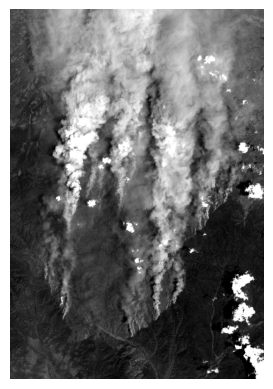

In [11]:
# NOTE: Should we align the bands?
arizona_path = os.path.join("Lansat", "arizona")
arizona_files = sorted(glob.glob(os.path.join(arizona_path, r'banda*.tif')))
print(arizona_files)
arizona_imgs = list(map(lambda x: rasterio.open(x).read(1).astype(np.uint8), arizona_files))
arizona_sample = arizona_imgs[0]
arizona_shapes = arizona_sample.shape
print(f'dtype: {arizona_sample.dtype}, shape: {arizona_sample.shape}, min: {np.min(arizona_sample)}, max: {np.max(arizona_sample)}')
plt.imshow(arizona_sample, 'gray')
plt.axis('off')
plt.show()

(1900, 1301, 3)


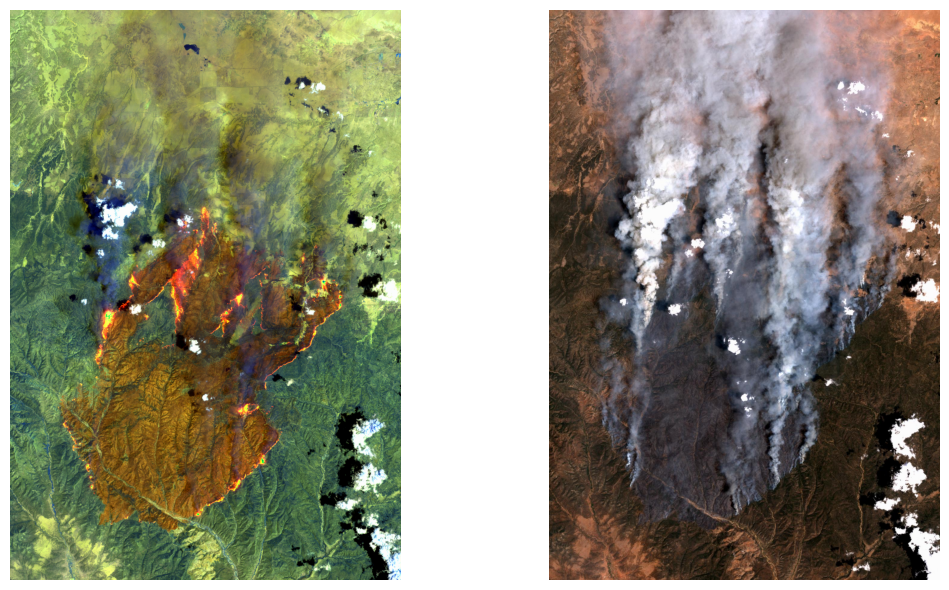

In [12]:
arizona_false_color = np.concat(
  [
    arizona_imgs[6].reshape(*arizona_shapes, 1),
    align_band(arizona_imgs[6], arizona_imgs[4]).reshape(*arizona_shapes, 1),
    align_band(arizona_imgs[6], arizona_imgs[3]).reshape(*arizona_shapes, 1)
  ], 
  axis=2
)
print(arizona_false_color.shape)
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 6))
example = cv2.cvtColor(cv2.imread(os.path.join(arizona_path, 'rgb.jpg'), cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
ax[1].imshow(example)
ax[1].set_axis_off()
ax[0].imshow(arizona_false_color)
ax[0].set_axis_off()
plt.show()

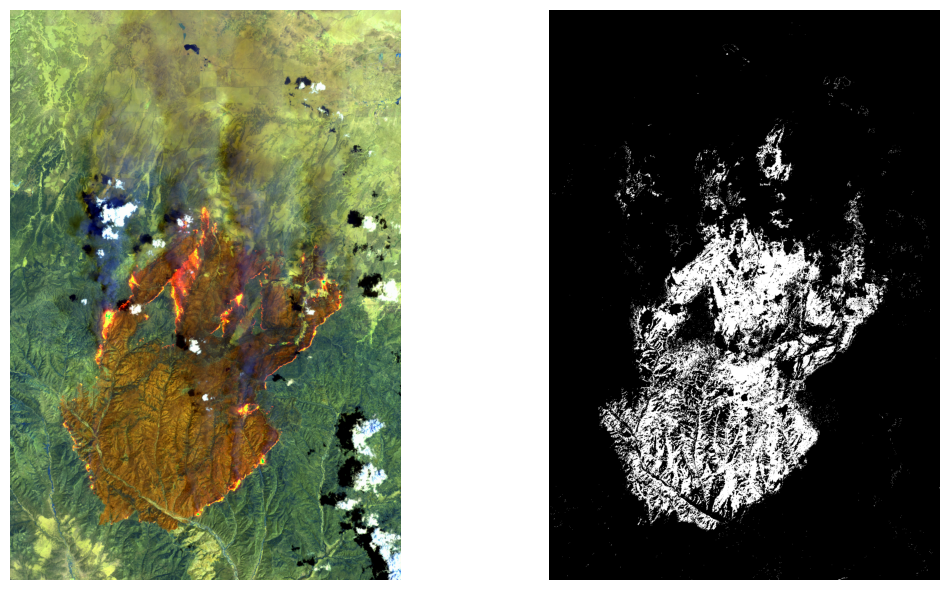

In [13]:
arizona_false_color_mask = cv2.inRange(
  arizona_false_color, 
  # Trying orange like color
  np.asarray([70, 0, 0]),
  # Trying orange like color
  np.asarray([255, 90, 90]),
)
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 6))
ax[0].imshow(arizona_false_color)
ax[0].set_axis_off()
ax[1].imshow(arizona_false_color_mask, 'gray')
ax[1].set_axis_off()
plt.show()

In [14]:
false_color_burnt_area = np.sum(np.where(arizona_false_color_mask > 0, 1, 0)) * area_per_pixel
print(f"Área estimada del incendio en Arizona (False-Color): {false_color_burnt_area:.2f} km²")

Área estimada del incendio en Arizona (False-Color): 292.96 km²


Lansat/arizona/banda4.tif Lansat/arizona/banda3.tif


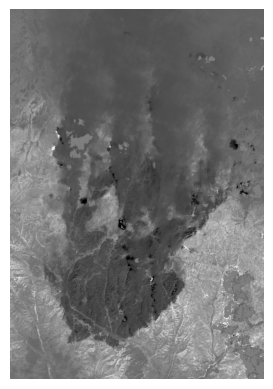

In [15]:
# https://www.usgs.gov/landsat-missions/landsat-normalized-difference-vegetation-index
# In Landsat 4-7, NDVI = (Band 4 – Band 3) / (Band 4 + Band 3).
print(arizona_files[3], arizona_files[2])
arizona_nir_band = arizona_imgs[3]
arizona_red_band = align_band(arizona_nir_band, arizona_imgs[2])
# Compute NDWI using OpenCV
arizona_nir_band = arizona_nir_band.astype(np.float32)
arizona_red_band = arizona_red_band.astype(np.float32)
ndvi = cv2.divide(cv2.subtract(arizona_nir_band, arizona_red_band), cv2.add(arizona_nir_band, arizona_red_band + 1e-10))
# Normalize to 0-255 for visualization
ndvi_vis = cv2.normalize(ndvi, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
plt.imshow(ndvi_vis, 'gray')
plt.axis('off')
plt.show()

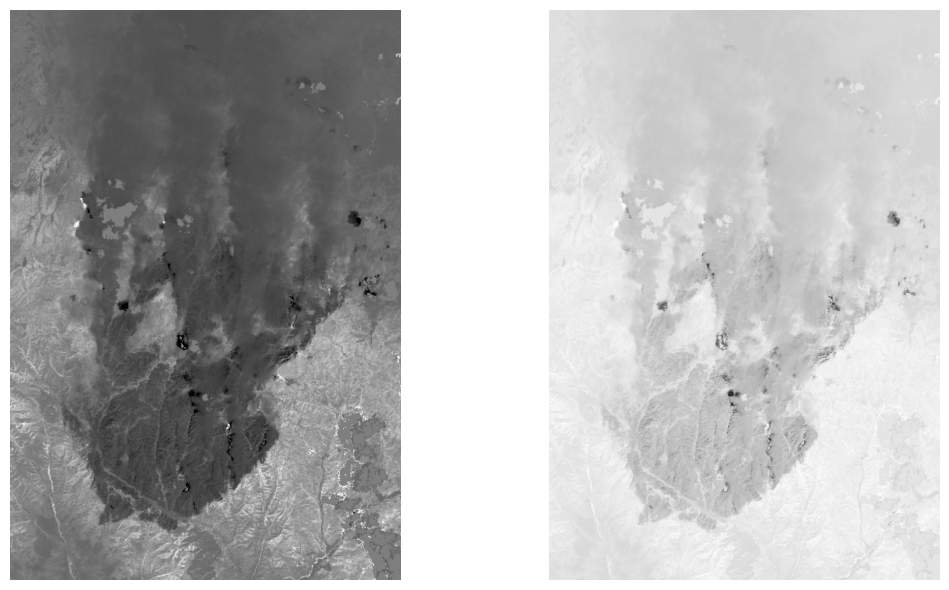

In [16]:
# [2] https://www.researchgate.net/publication/314089082_Burnt_areas_detection_and_mapping_using_vegetation_indices
msavi = (2 * arizona_nir_band + 1 - np.sqrt((2 * arizona_nir_band + 1) ** 2 - 8 * (arizona_nir_band - arizona_red_band))) / 2
msavi_vis = cv2.normalize(msavi, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
# bai = 1 / ((0.1 - arizona_red_band) ** 2 + (0.06 - arizona_nir_band) ** 2)
# NOTE: Can't correctly visualize the bai index... something might be wrong?
# bai_vis = cv2.normalize(bai, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
images = [
  ndvi_vis,
  msavi_vis,
  # bai_vis
]
fig, ax = plt.subplots(1, len(images), tight_layout=True, figsize=(12, 6))
for i, img in enumerate(images):
  ax[i].imshow(img, 'gray')
  ax[i].set_axis_off()
plt.show()

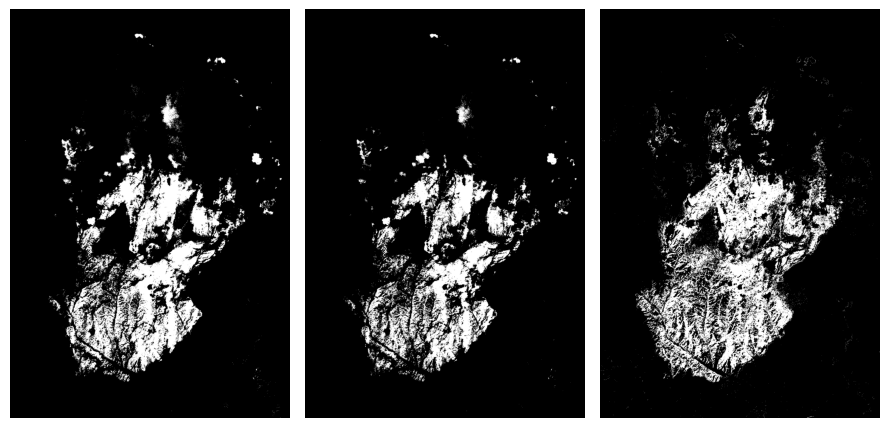

In [17]:
# Umbral de NDVI 
thresh_ndvi = -0.4
thresh_msavi = -1.4
mask_ndvi = np.where(ndvi < thresh_ndvi, 1, 0).astype(np.uint8)
mask_msavi = np.where(msavi < thresh_msavi, 1, 0).astype(np.uint8)
images = [ 
  mask_ndvi, 
  mask_msavi,
  arizona_false_color_mask,
]
fig, ax = plt.subplots(1, len(images), tight_layout=True, figsize=(9, 12))
for i, img in enumerate(images):
  ax[i].imshow(img, 'gray')
  ax[i].set_axis_off()
plt.show()

In [18]:
import numpy as np
burnt_area_ndvi = np.sum(mask_ndvi) * area_per_pixel
burnt_area_msavi = np.sum(mask_msavi) * area_per_pixel
print(f"Área estimada del incendio en Arizona (NDVI): {burnt_area_ndvi:.2f} km²")
print(f"Área estimada del incendio en Arizona (MSAVI): {burnt_area_msavi:.2f} km²")

Área estimada del incendio en Arizona (NDVI): 253.80 km²
Área estimada del incendio en Arizona (MSAVI): 206.85 km²


## NMDI

<img style="display:block;margin-left:auto;margin-right:auto;width:50%;" alt="Diagrama de flujo del índice NMDI" src="NMDI-flowchart.gif" title="Diagrama de flujo del índice NMDI"/>

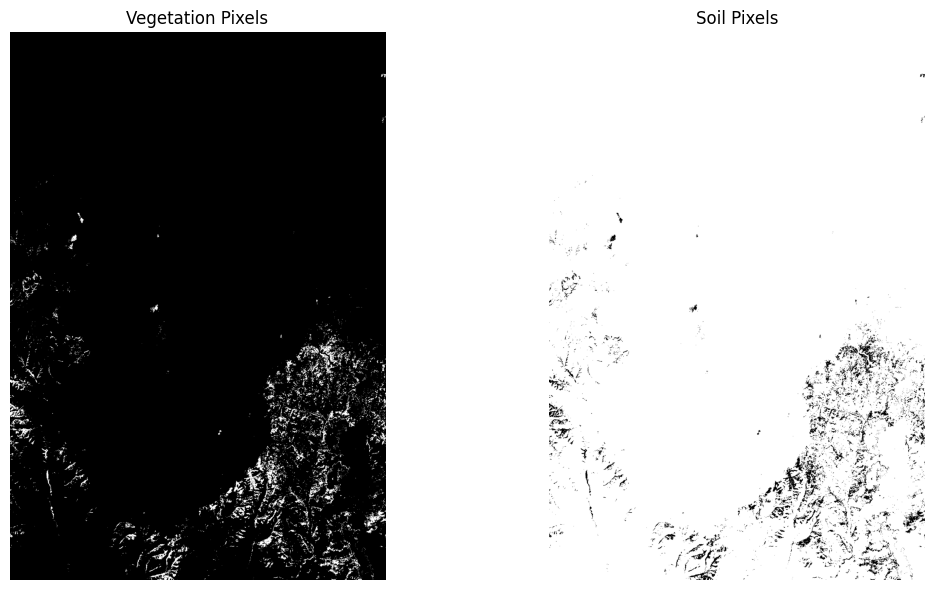

In [19]:
arizona_vegetation = np.where(ndvi >= 0.4, 1, 0).astype(np.uint8)
arizona_soil = cv2.bitwise_not(arizona_vegetation)
images = [ 
  ("Vegetation Pixels", arizona_vegetation) ,
  ("Soil Pixels", arizona_soil),
]
fig, ax = plt.subplots(1, len(images), tight_layout=True, figsize=(12, 6))
for i, (title, image) in enumerate(images):
  ax[i].imshow(image, 'gray')
  ax[i].set_title(title)
  ax[i].set_axis_off()
plt.show()

Lansat/arizona/banda4.tif Lansat/arizona/banda5.tif Lansat/arizona/banda7.tif


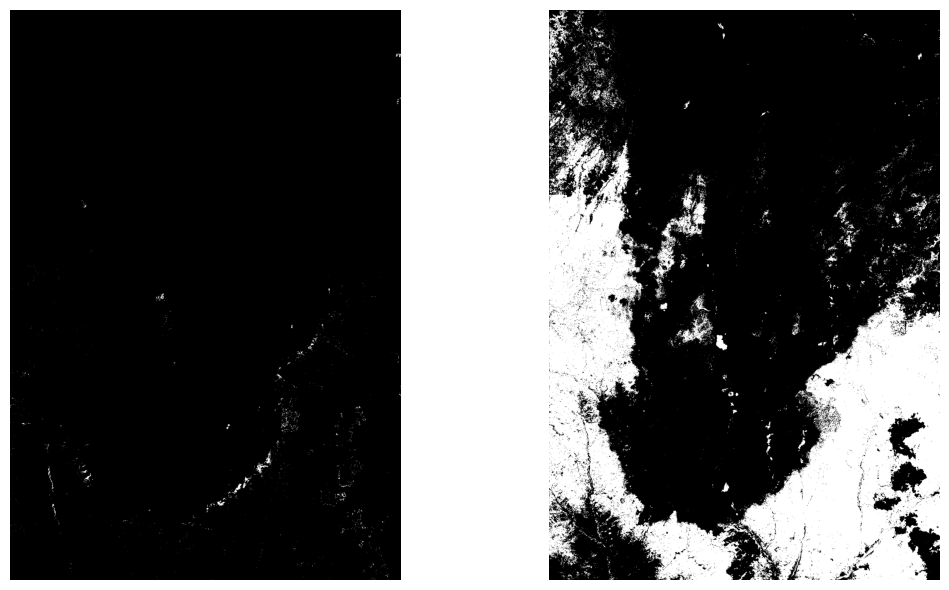

In [20]:
# NMDI_v = (Band4 - (Band5 - Band7)) / (Band4 + (Band5 - Band7))
# NMDI_s = 0.9 - (Band4 - (Band5 - Band7)) / (Band4 + (Band5 - Band7))
print(arizona_files[3], arizona_files[4], arizona_files[6])
arizona_nir_band = arizona_imgs[3]
arizona_swir_band1 = align_band(arizona_nir_band, arizona_imgs[4])
arizona_swir_band2 = align_band(arizona_nir_band, arizona_imgs[6])
nmdi_v = cv2.divide(
  cv2.subtract(
    arizona_nir_band,
    cv2.subtract(
      arizona_swir_band1,
      arizona_swir_band2,
      None,
      mask=arizona_vegetation
    ),
    mask=arizona_vegetation
  ), 
  cv2.add(
    arizona_nir_band,
    cv2.subtract(
      arizona_swir_band1,
      arizona_swir_band2,
      None,
      mask=arizona_vegetation
    ),
    mask=arizona_vegetation
  ), 
) 
nmdi_s = 0.9 - cv2.divide(
  cv2.subtract(
    arizona_nir_band,
    cv2.subtract(
      arizona_swir_band1,
      arizona_swir_band2,
      None,
      mask=arizona_soil
    ),
    mask=arizona_soil
  ), 
  cv2.add(
    arizona_nir_band,
    cv2.subtract(
      arizona_swir_band1,
      arizona_swir_band2,
      None,
      mask=arizona_soil
    ),
    mask=arizona_soil
  ), 
) 
nmdi_v_vis = cv2.normalize(nmdi_v, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
nmdi_s_vis = cv2.normalize(nmdi_s, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
images = [ 
  nmdi_v_vis, 
  nmdi_s_vis, 
]
fig, ax = plt.subplots(1, len(images), tight_layout=True, figsize=(12, 6))
for i, img in enumerate(images):
  ax[i].imshow(img, 'gray')
  ax[i].set_axis_off()
plt.show()

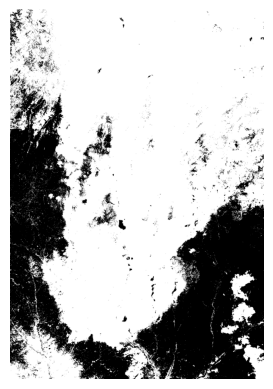

In [21]:
nmdi_v_mask = np.where(nmdi_v <= 0.2, 1, 0).astype(np.uint8)
nmdi_s_mask = np.where(nmdi_s <= 0.2, 1, 0).astype(np.uint8)
plt.imshow(nmdi_v_mask + nmdi_s_mask, 'gray')
plt.axis('off')
plt.show()

In [22]:
import numpy as np
burnt_area_nmdi = ((nmdi_v_mask + nmdi_s_mask).sum()) * area_per_pixel
print(f"Área estimada del incendio en Arizona (NMDI): {burnt_area_nmdi:.2f} km²")

Área estimada del incendio en Arizona (NMDI): 3763.94 km²


# Adra

['Lansat/adra/banda1.tif', 'Lansat/adra/banda2.tif', 'Lansat/adra/banda3.tif', 'Lansat/adra/banda4.tif', 'Lansat/adra/banda5.tif', 'Lansat/adra/banda61.tif', 'Lansat/adra/banda62.tif', 'Lansat/adra/banda7.tif', 'Lansat/adra/banda8.tif']
dtype: uint8, shape: (256, 256), min: 57, max: 204


/home/briansenas/Documents/landsat-remote-sensing/.venv/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


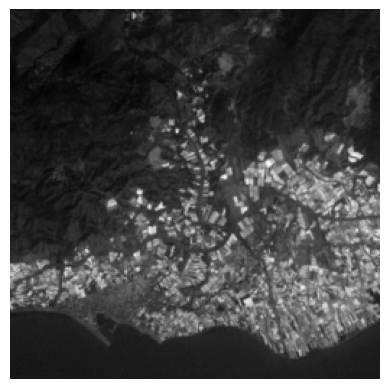

In [29]:
adra_path = os.path.join("Lansat", "adra")
adra_files = sorted(glob.glob(os.path.join(adra_path, 'banda*.tif')))
print(adra_files)
adra_imgs = list(map(lambda x: rasterio.open(x).read(1).astype(np.uint8), adra_files))
adra_sample = adra_imgs[0]
adra_shapes = adra_sample.shape
print(f'dtype: {adra_sample.dtype}, shape: {adra_sample.shape}, min: {np.min(adra_sample)}, max: {np.max(adra_sample)}')
plt.imshow(adra_sample, 'gray')
plt.axis('off')
plt.show()

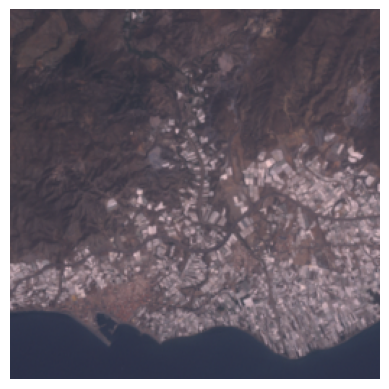

In [30]:
# Band3 (Red) + Band2(Green) + Band1 (Blue)
adra_rgb = cv2.merge([adra_imgs[2], adra_imgs[1], adra_imgs[0]])
plt.imshow(adra_rgb)
plt.axis('off')
plt.show()

## HSV

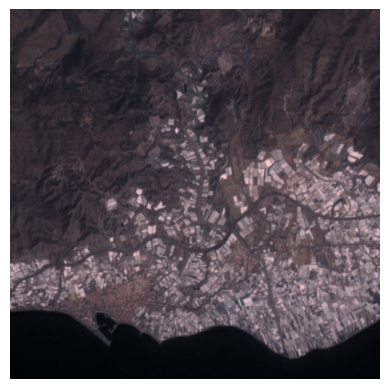

In [ ]:
# [4] http://www.shadedrelief.com/landsat8/landsat8panchrom.html
adra_pan_norm = cv2.normalize(adra_imgs[-1], None, 0, 255, cv2.NORM_MINMAX)
adra_rgb_upsample = cv2.resize(adra_rgb, adra_pan_norm.shape, None, interpolation=cv2.INTER_CUBIC)
adra_hsv = cv2.cvtColor(adra_rgb_upsample, cv2.COLOR_RGB2HSV)
# Split the HSV image into Hue, Saturation, and Value (Luminance)
h, s, v = cv2.split(adra_hsv)
v = adra_pan_norm
adra_hsv_enhanced = cv2.merge([h, s, v])
adra_rgb_upsample_enhanced = cv2.cvtColor(adra_hsv_enhanced, cv2.COLOR_HSV2RGB)
plt.imshow(adra_rgb_upsample_enhanced)
plt.axis('off')
plt.show()

## Wavelet

## Brovey

# Bibliografía

1. [Normalized Difference Water Index](https://en.wikipedia.org/wiki/Normalized_difference_water_index)
2. [Burnt areas detection and mapping using vegetation indices](https://www.researchgate.net/publication/314089082_Burnt_areas_detection_and_mapping_using_vegetation_indices)
3. [Forest fire detection using the normalized multi-band drought index (NMDI) with satellite measurements](https://www.sciencedirect.com/science/article/abs/pii/S0168192308001871)
4. [Landsat 8 Photoshop Tutorial. Pancromatic Sharpening](http://www.shadedrelief.com/landsat8/landsat8panchrom.html)

# Apéndice

In [23]:
# Align all images: 
reference = texas_imgs_clean[0]
texas_imgs_clean_aligned = [reference]
for img in texas_imgs_clean[1:]:
  aligned = align_band(reference, img, threshold=0.85, visualize=False)
  texas_imgs_clean_aligned.append(aligned)

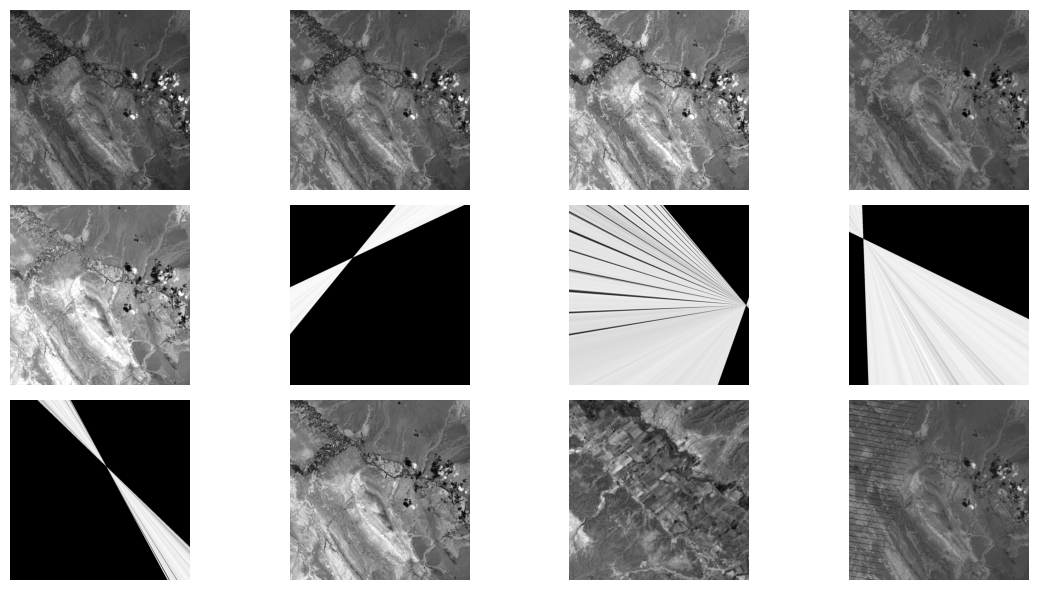

In [24]:
fig, ax = plot_array(3, 4, texas_imgs_clean_aligned, tight_layout=True, figsize=(12, 6))
for i in range(len(ax)):
  ax[i].set_axis_off()
plt.show()

Se observa que SIFT no parece ser lo más adecuado para hacer homografías entre las imágenes de las bandas 6 con respecto a la imagen 1.